<a href="https://colab.research.google.com/github/GoTudering/Deep_Learning_Study/blob/main/training_NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input,train_target),(test_input,test_target)=\
  keras.datasets.fashion_mnist.load_data()
train_scaled=train_input/255.0
train_scaled, val_scaled, train_target, val_target=train_test_split(train_scaled,train_target,test_size=0.2,random_state=42)

4431872/4422102 [==============================] - 0s 0us/step


In [9]:
#model_fn함수에 a_layer매개변수로 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것임
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100,activation='relu'))
    if a_layer:
      model.add(a_layer)
    model.add(keras.layers.Dense(10,activation='softmax'))
    return model

In [10]:
model = model_fn()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [12]:
#fit() 메서드의 경과를 history 변수에 담아봄
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=5,verbose=0)#verbose 매개변수는 훈련 과정 출력을 조절함
#기본값 1로 에포크마다 진행 막대와 함께 손실 등의 지표가 출력됨
#verbose 2면 진행 막대를 빼고 출력
#verbose 0은 훈련 과정을 나타내지 않음

In [14]:
#history 객체에는 훈련 측정값이 담겨 있는 history 딕셔너리가 들어있음
print(history.history.keys())
#손실은 기본적으로 에포크마다 손실을 계산하기에 들어있음
#정확도는 compile할 때 metrics 매개변수에 'accuracy'를 추가했기 때문에 들어있음

dict_keys(['loss', 'accuracy'])


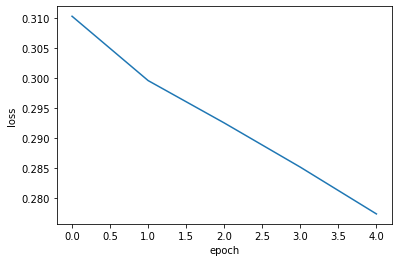

In [16]:
#history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 단순한 리스트임

import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

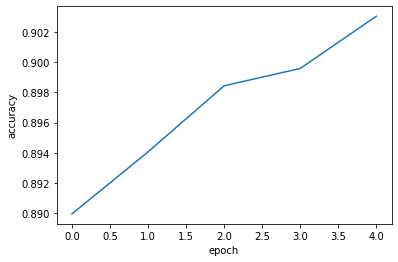

In [17]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

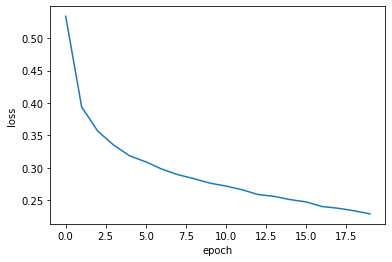

In [18]:
#epoch가 커질 수록 손실이 줄고 정확도가 올라가니 epoch를 늘려볼까?
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [19]:
#손실은 감소했지만 이게 더 나은 모델이라 할 수 있을까?
#과대적합일 수도 있음
#훈련 세트 뿐만 아니라 검증 세트 점수 또한 필요함

#epoch마다 검증 손실을 계산하기 위해 케라스 모델의 fit()메서드에 검증 데이터를 전달할 수 있음
#validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달해야함
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target))

In [20]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


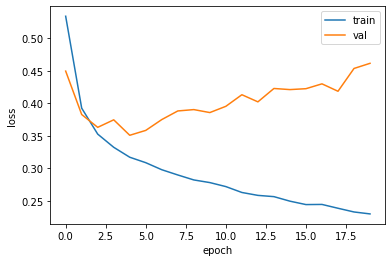

In [22]:
#그래프 그려서 비교
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

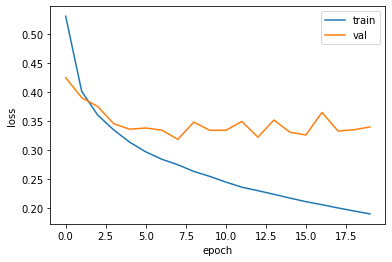

In [23]:
#옵티마이저 하이퍼파라미터를 조정하여 과대적합을 완화시켜보자

#Adam이용
model = model_fn()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

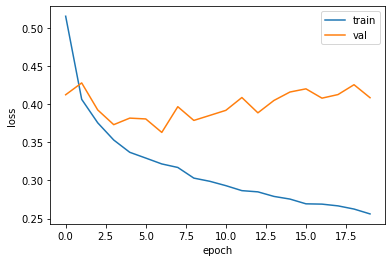

In [25]:
#여전히 요동이 남아 있지만 전반적인 감소 추세가 이어지고 있음
#이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 보여줌
#더 나은 손실 곡선을 얻으려면 학습률을 조정해서 다시 시도해 볼 수 있음
model = model_fn()
adam = keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

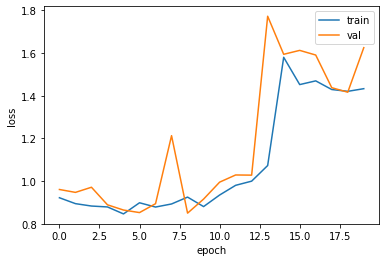

In [26]:
model = model_fn()
adam = keras.optimizers.Adam(learning_rate=0.05)
model.compile(optimizer=adam,loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [27]:
#과대적합을 막는 방법 중 드롭아웃dropout이 있음
#이는 은닉층에 있는 일부 뉴런을 0으로 만듦
#얼마나 많은 뉴런을 드롭할지는 하이퍼파라미터임
model=model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               78500     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


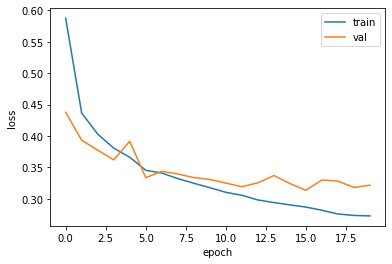

In [28]:
#훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 함
#텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 자동으로 드롭아웃을 적용하지 않음
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [29]:
#epoch 10정도가 과대적합이 아님
#epoch 10으로 다시 지정하고 모델을 훈련

#모델 저장과 복원

model=model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
history=model.fit(train_scaled,train_target,epochs=10,verbose=0,validation_data=(val_scaled,val_target))

In [30]:
#훈련된 모델의 파라미터를 저장하는 메서드는 save_weights()임
#기본적으로 이 메서드는 텐서플로의 체크포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5포맷으로 저장함

model.save_weights('model-weights.h5')

In [32]:
#모델 구조와 모델 파라미터를 함께 저장하는 save()메서드도 있음
#기본적으로 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'일 경우 HDF5포맷으로 저장함
model.save('model-whole.h5')

In [33]:
#잘 만들어졌나?
!ls -al *.h5

-rw-r--r-- 1 root root 332480 Oct 10 18:09 model-weights.h5
-rw-r--r-- 1 root root 981736 Oct 10 18:11 model-whole.h5


In [35]:
#두 가지 실험을 해보자
#첫 번째 실험

#훈련하지 않은 새로운 모델을 만들고 modell-weights.h5파일에서 훈련된 모델 파라미터를 읽어서 사용하자
model=model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

In [37]:
#모델의 검증 정확도를 확인해야함
#predict()을 사용할건데 다중 분류이기에 샘플마다 10개의 클래스에 대한 확률로 반환됨
#패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수는 12000개이기 때문에 predict() 메서드는 (12000,10) 크기의 배열을 반환함
#10개 확률 중 가장 큰 값의 인덱스를 골라 다깃 레이블과 비교하여 정확도를 계산해야함
import numpy as np
val_labels = np.argmax(model.predict(val_scaled),axis=-1) #argmax로 최대값을 가진 index를 받음 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고름
#이 경우는 2차원이기에 axis=0, axis=1이 있었기에 axis=-1은 마지막 차원인 axis=1을 의미
print(np.mean(val_labels == val_target))

0.8810833333333333


In [38]:
#두 번째 실험

#아예 model-whole.h5파일에서 새로운 모델을 만들어 바로 사용
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3321 - accuracy: 0.8811


[0.33207327127456665, 0.8810833096504211]

In [39]:
#생각해보면 20번의 에포크해보고 상승하니 과대적합 되지 않은 에포크만큼 다시 훈련했음
#한 번에 못하나?

#콜백 callback
#훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체
#keras.callbacks 패키지 아래에 있는 클래스들
#fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용
#여기서 사용할 ModelCheckpoint 콜백은 기본적으로 에포크마다 모델을 저장함
#save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있음
#저장될 파일 이름을 'best-model.h5'로 지정하여 콜백을 적용해봄
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',save_best_only=True)
model.fit(train_scaled,train_target,epochs=20,verbose=0,validation_data=(val_scaled,val_target),callbacks=[checkpoint_cb])

In [40]:
#모델이 훈련한 후에 best-model.h5에 최상의 검증 점수를 낸 모델이 저장됨
model=keras.models.load_model('best-model.h5')
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3129 - accuracy: 0.8907


[0.31285738945007324, 0.890749990940094]

In [41]:
#콜백이 가장 낮은 검증 점수 모델을 자동으로 저장해줬지만 결국 20번 훈련해야함
#검증 점수가 상승하기 시작하면 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없음
#조기 종료 early stopping을 통해 컴퓨터 자원과 시간을 아낄 수 있음
#조기 종료는 또한 과대적합되는 것을 막아주기에 규제 방법 중 하나로 생각할 수도 있음
#케라스는 조기 종료를 위한 EarlyStopping콜백을 제공함
#patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수를 지정함
#restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌림
#EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있음
#훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌림
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5',save_best_only=True)
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
history = model.fit(train_scaled,train_target,epochs=20,verbose=0,
                    validation_data=(val_scaled,val_target),
                    callbacks=[checkpoint_cb,early_stopping_cb])

In [42]:
#훈련을 마치고 나면 몇 번째 에포크에서 훈련이 중지되었는지 early_stopping_cb 객체의 stopped_epoch속성에서 확인할 수 있음
print(early_stopping_cb.stopped_epoch)

13


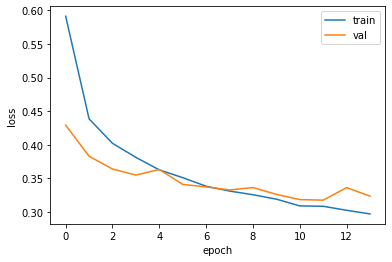

In [43]:
#에포크 횟수가 0부터 시작이기에 14번째 에포크이고 patience가 2기에 최상의 에포크는 12임
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

In [44]:
#성능 테스트
model.evaluate(val_scaled,val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3173 - accuracy: 0.8876


[0.3173450231552124, 0.887583315372467]

In [45]:
test_scaled=test_input/255.0
model.evaluate(test_scaled,test_target)

313/313 [==============================] - 1s 2ms/step - loss: 0.3451 - accuracy: 0.8780


[0.3450835049152374, 0.878000020980835]